In [19]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from numpy import isnan
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import (VarianceThreshold, SelectKBest, SelectPercentile, 
                                       SelectFdr, SelectFpr, SelectFwe, GenericUnivariateSelect) 
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier


In [20]:
def get_training_dataset(binary=False):
    df = pd.read_csv('../UNSW-NB15/data/UNSW_NB15_training-set_cleaned.csv')
    labels = df.iloc[:, -1] if binary else df.iloc[:, -2]
    return df.iloc[:, 0:-2], labels

def get_testing_dataset(binary=False):
    df = pd.read_csv('../UNSW-NB15/data/UNSW_NB15_testing-set_cleaned.csv')
    labels = df.iloc[:, -1] if binary else df.iloc[:, -2]
    return df.iloc[:, 0:-2], labels

In [21]:
def get_models():
    models = (RandomForestClassifier(n_jobs=-1),)

    for model in models:
      yield model

def test_mult_model(model, selector=None, scaler=None):
    X_train, y_train = get_training_dataset()
    X_test, y_test = get_testing_dataset()

    if scaler:
      X_train = scaler.fit_transform(X_train)
      X_test = scaler.transform(X_test)

    X_train_num, X_train_cat = X_train.iloc[:, 0:39], X_train.iloc[:, 39:] 
    X_test_num, X_test_cat = X_test.iloc[:, 0:39], X_test.iloc[:, 39:]

    if selector:
      X_train_num = selector.fit_transform(X_train_num, y_train)
      X_test_num = selector.transform(X_test_num)

    X_train = np.concatenate((X_train_num, X_train_cat), axis=1)
    X_test = np.concatenate((X_test_num, X_test_cat), axis=1)

    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)

    return (
            accuracy_score(y_test, y_preds)*100, 
            precision_score(y_test, y_preds, average='weighted')*100, 
            recall_score(y_test, y_preds, average='weighted')*100, 
            f1_score(y_test, y_preds, average='weighted')*100
            )

In [22]:
def print_results(selector, accuracy, f1):
    print("")

    print(f"\t{selector}:" if selector else "\tWithout selection:")

    print("")
    if not isnan(accuracy):
      print(f"\t\taccuracy: {accuracy}")
    if not isnan(f1):
      print(f"\t\tf1-score: {f1}")

    print("")

def eval(model):
    print(f"{type(model).__name__}:")
    # print_results(*test_mult_model(model))
    result_df = pd.DataFrame(columns=["score_func", "features", "accuracy", "precison", "recall", "f1-score"])
    for score_func in (chi2, f_classif, mutual_info_classif):
      for k in range(10, 35):
        result_df.loc[len(result_df.index)] = [score_func.__name__, k, *test_mult_model(model, selector=SelectKBest(score_func=score_func, k=k))]

    result_dfm = pd.melt(result_df, id_vars=("score_func", "features"), value_vars=("accuracy", "precison", "recall", "f1-score"), var_name="metric", value_name="percentage")
    g = sb.FacetGrid(result_dfm, row="score_func", sharex=False, height=6, aspect=4)
    g.map_dataframe(sb.barplot, data=result_dfm, x="features", y="percentage", hue="metric", palette=["tab:red", "tab:green", "tab:orange", "tab:blue"])
    g.add_legend()
    g.tight_layout()

    print(result_df)
    
    # for p in (.9,.8, .7, .6):
    #   print_results(*test_mult_model(model, selector=VarianceThreshold(p * (1 - p))))

In [23]:
model = get_models()

RandomForestClassifier:


             score_func  features   accuracy   precison     recall   f1-score
0                  chi2        10  71.460632  80.018973  71.460632  73.147416
1                  chi2        11  71.417235  79.666681  71.417235  73.068755
2                  chi2        12  71.634222  77.920987  71.634222  73.180000
3                  chi2        13  72.297582  79.304259  72.297582  73.660983
4                  chi2        14  73.270924  80.357490  73.270924  74.458114
..                  ...       ...        ...        ...        ...        ...
70  mutual_info_classif        30  78.893986  84.991037  78.893986  79.801679
71  mutual_info_classif        31  78.933664  85.336321  78.933664  79.757004
72  mutual_info_classif        32  78.902666  85.168239  78.902666  79.751819
73  mutual_info_classif        33  78.783633  85.090570  78.783633  79.678121
74  mutual_info_classif        34  78.901426  85.260376  78.901426  79.812194

[75 rows x 6 columns]


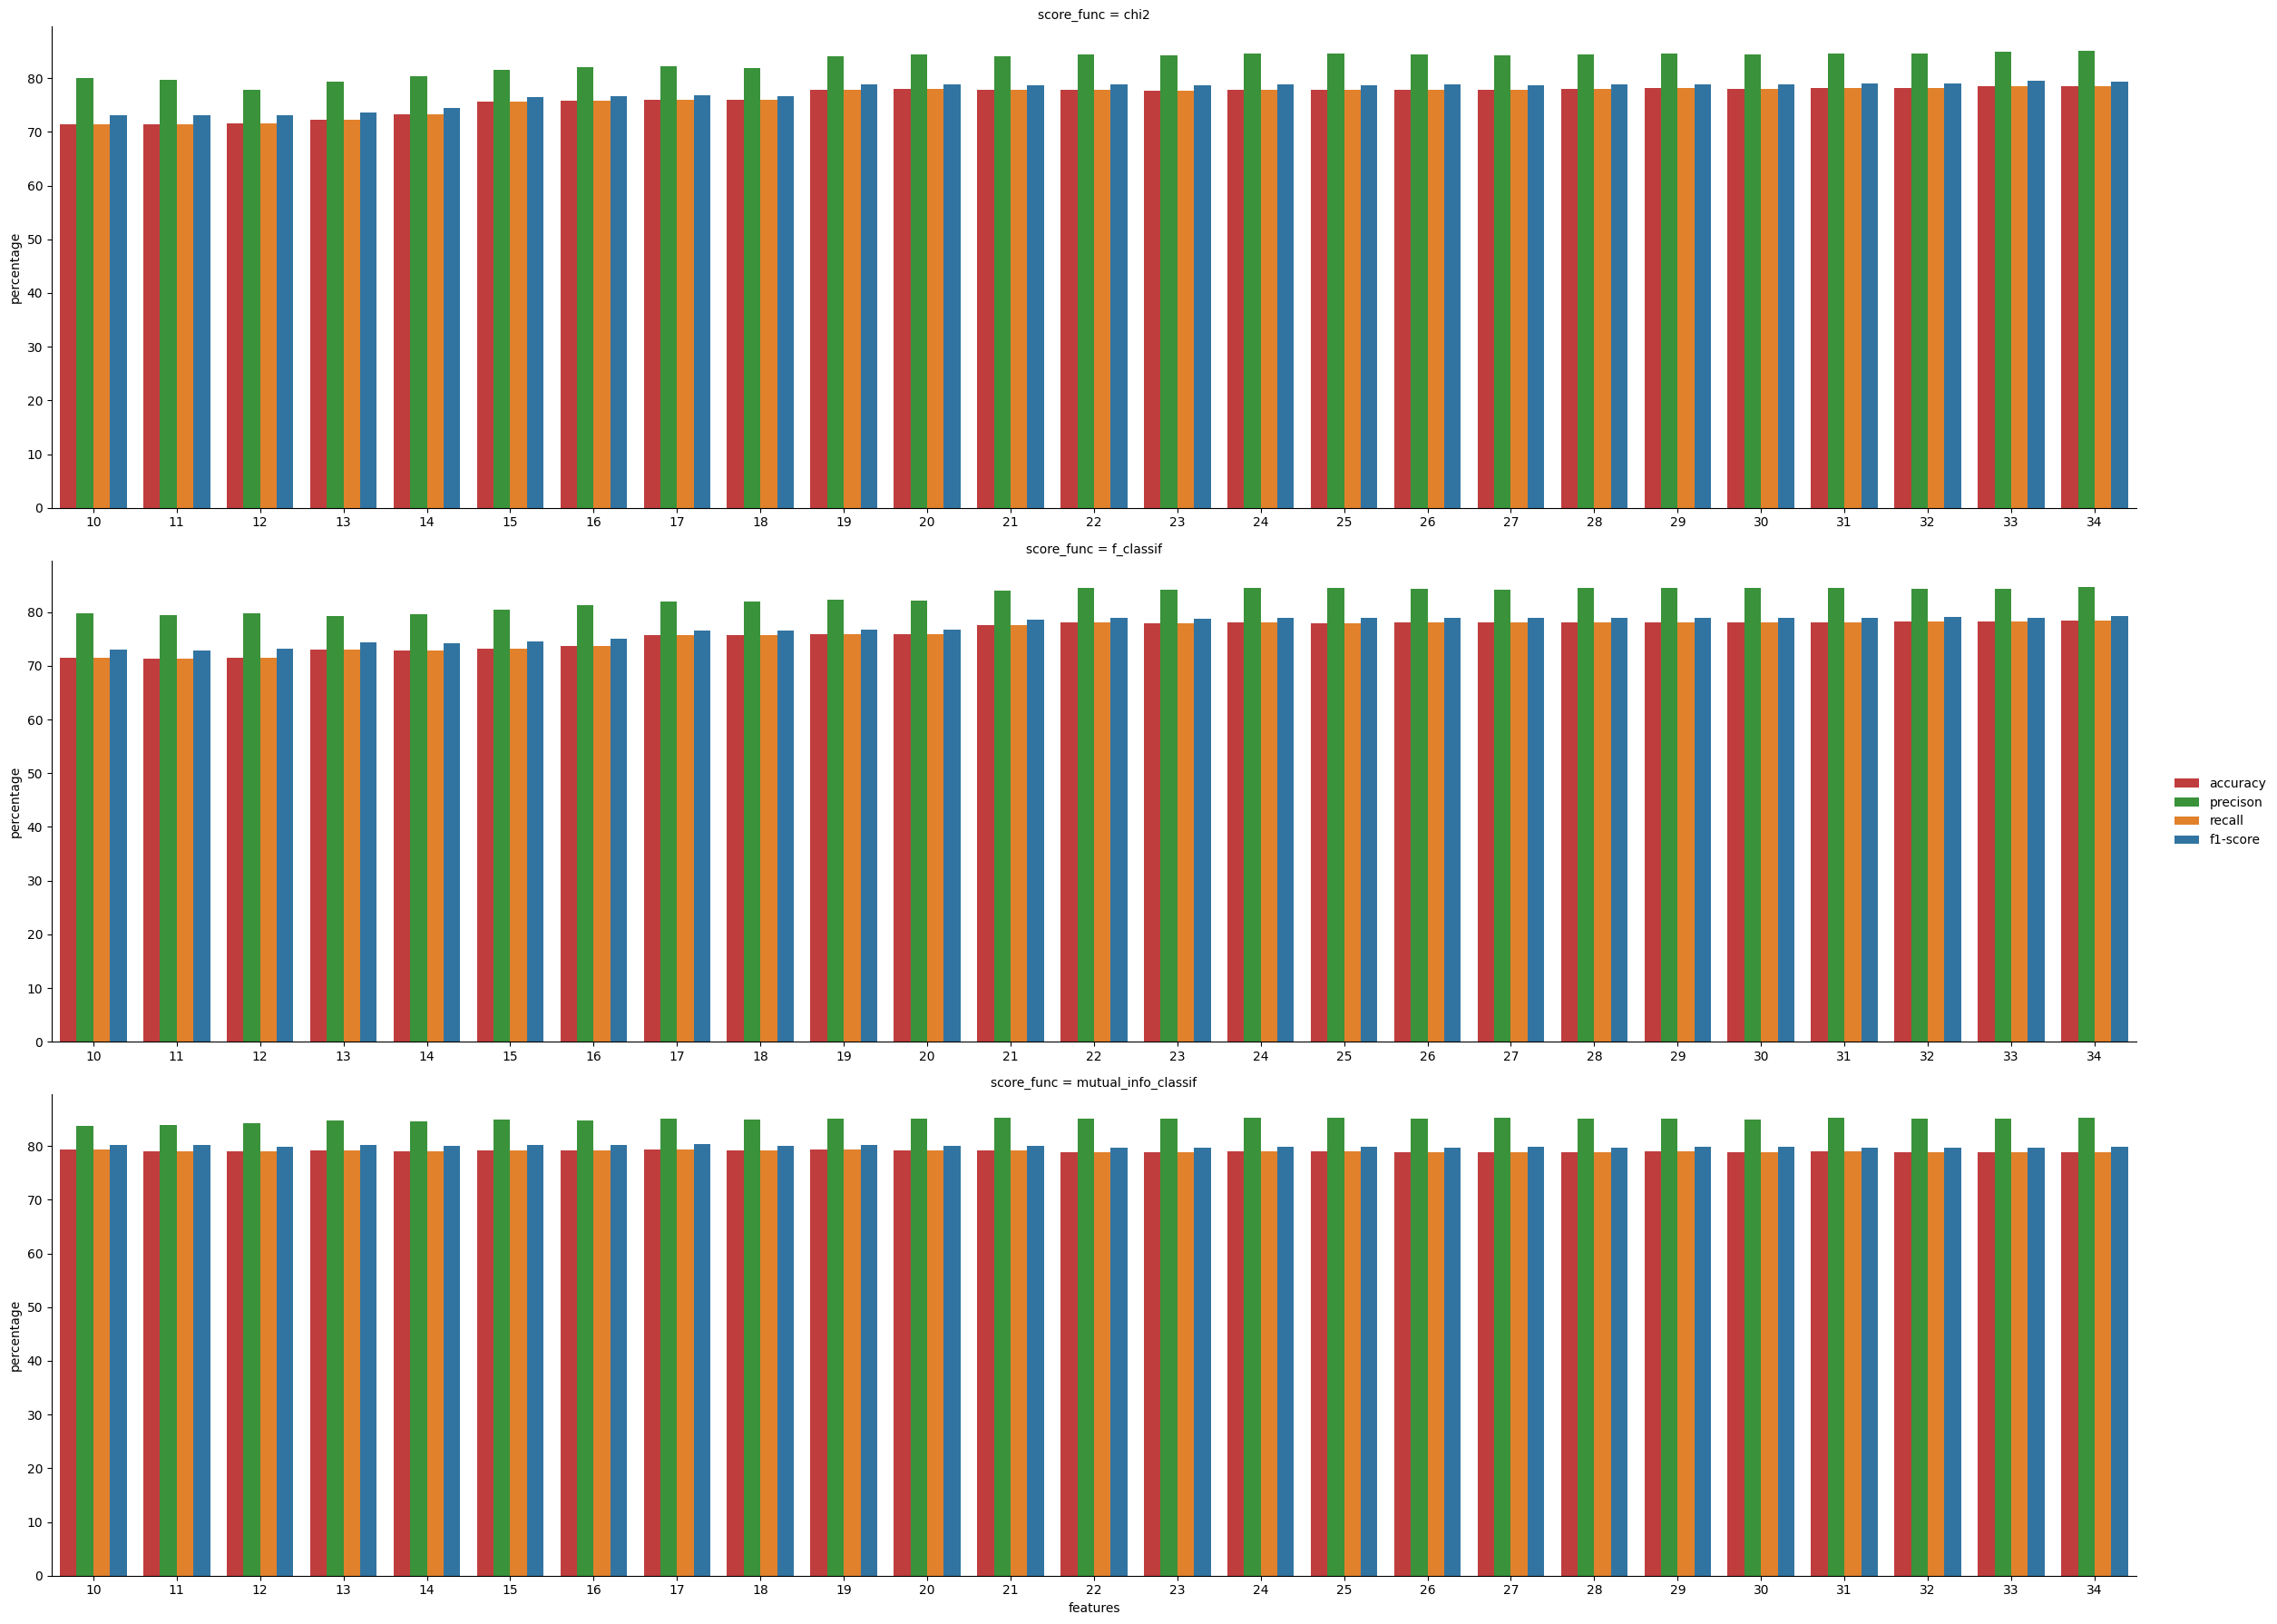

In [24]:
eval(next(model))